<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/LoRA_Tuning_PEFT_bloomz_560m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from: https://github.com/peremartra/Large-Language-Model-Notebooks-Course
选择的基础模型是 bloomz-560模型参数量小，可以直接使用cpu来微调

# LoRA调整

在这份笔记本中，我将介绍如何使用PEFT库对预训练模型应用LoRA调整。

要查看与PEFT兼容的完整模型列表，请参考它们的[文档](https://huggingface.co/docs/peft/main/en/index#supported-methods)。

可以使用PEFT进行训练的模型家族的简短示例包括：Bloom、Llama、GPT-J、GPT-2、BERT 等等。 Hugging Face 正在努力将更多的模型引入到该库中。

## LoRA调整简介
LoRA是一种重新参数化技术。它的操作简单、复杂，同时也很巧妙。它涉及将要训练的矩阵的大小缩小，通过将它们分成这样一种方式来相乘，使它们产生原始矩阵。

被修改的权重是缩小后的矩阵的权重，而不是原始矩阵。最好通过图像进行可视化。

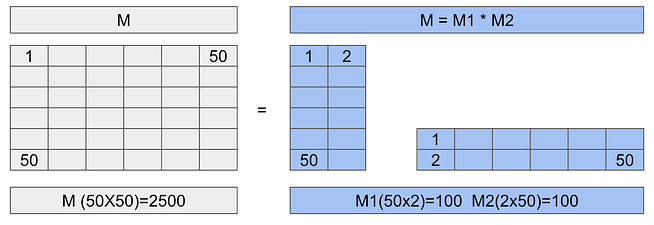

我们有一个原始的50x50矩阵，这意味着我们需要修改大约2500个参数。然而，正如我们所知道的，如果我们将两个(2x50)和(50x2)的矩阵相乘，我们就会得到一个50x50的矩阵。然而，这两个矩阵只由每个100个参数组成。换句话说，对于缩小后的矩阵，我们只需要修改200个参数，而不是原始矩阵的2500个参数。这代表了92%的减少，原始矩阵越大，节省的百分比就越大。

在像GPT-3或任何当前使用LoRA的语言模型中，我们可能只需要训练约原始参数的0.02%。这个比例对于每个模型都有所不同。最好的部分是，得到的结果与完全微调的结果非常相似，在某些情况下，甚至可能更好。

# 加载PEFT和Datasets库。

PEFT库包含了Hugging Face对不同微调技术的实现，例如LoRA调整。

使用Datasets库，我们可以访问大量的数据集。

In [1]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


```python
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Import necessary classes to import the model and the tokenizer
# Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("Bloom/bloom-tiny")
model = AutoModelForMaskedLM.from_pretrained("Bloom/bloom-tiny")
```

从transformers库中导入必要的类来导入模型和分词器。

然后我们可以加载分词器和模型。

Bloom是可以使用Prompt Tuning在PEFT库中训练的最小和最智能的模型之一。您可以使用Bloom Family中的任何一个模型，我鼓励您至少使用两个模型并查看它们之间的差异。

我使用最小的模型只是为了花费更少的时间进行训练，并避免在Colab中出现内存问题。

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


In [8]:
print(tokenizer)
print(foundation_model)
print(foundation_model.config)

BloomTokenizerFast(name_or_path='bigscience/bloomz-560m', vocab_size=250680, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
 

## Inference with the pre-trained model.
我将使用预训练模型进行一次测试，而不进行微调，以查看微调后是否会有变化。


In [15]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

用于微调的数据集包含用于与大型语言模型配对的提示。

我将请求像是激励教练一样的预训练模型。

In [4]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


["I want you to act as a motivational coach.  Don't be afraid of being challenged."]


不确定答案是否正确，但肯定不是一个提示。如果我们希望模型像提示工程师一样运行，我们需要对其进行训练。

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [6]:
print(train_sample[:1])

{'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 2670, 3968, 9361, 632, 269, 4

# Fine-Tuning-LoRA


In [9]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)
print(lora_config)

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=4, target_modules={'query_key_value'}, lora_alpha=1, lora_dropout=0.05, fan_in_fan_out=False, bias='lora_only', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})


**r**是最重要的参数，它定义了将训练多少个参数。数值越大，训练的参数就越多，但这意味着模型将能够学习更复杂的输入和输出之间的关系。

您可以在[Hugging Face文档](https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)中找到**target_modules**的列表。

**lora_dropout**类似于常规的dropout，用于避免过拟合。

**bias**。我在是否使用*none*或*lora_only*之间犹豫不决。对于文本分类，最常见的值是none，而对于聊天或问答，常见的值是*all*或*lora_only*。

**task_type**。指示模型正在训练的任务类型。在本例中，是文本生成。

### 创建PEFT模型。

In [10]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


与预训练模型中的总参数数量相比，可训练参数的数量确实非常少。

In [7]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

在TrainingArgs中，我们通知训练的周期数、输出目录和学习率。

In [13]:
#Creating the TrainingArgs
import torch
import transformers
from transformers import TrainingArguments, Trainer

use_cpu= False if torch.cuda.is_available() else True
print(use_cpu)

training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=use_cpu
)
print(training_args)

True
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=True,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=False,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transform

现在我们可以训练模型了。
要训练模型，我们需要：


*   PEFT模型。
*   训练参数（training_args）。
*   数据集（Dataset）。
*   DataCollator的结果，即准备好以块形式进行处理的数据集。

In [13]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=14, training_loss=2.7270480564662387, metrics={'train_runtime': 255.1595, 'train_samples_per_second': 0.392, 'train_steps_per_second': 0.055, 'total_flos': 20073085894656.0, 'train_loss': 2.7270480564662387, 'epoch': 2.0})

In [16]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [17]:
tokenizer.save_pretrained(peft_model_path)


('./peft_lab_outputs/lora_model/tokenizer_config.json',
 './peft_lab_outputs/lora_model/special_tokens_map.json',
 './peft_lab_outputs/lora_model/tokenizer.json')

In [8]:
import peft,os
from peft import LoraConfig, get_peft_model, PeftModel
peft_model_path = os.path.join(output_directory, f"lora_model")

#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

In [9]:
print(loaded_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3072, bias=False)
                )
                (lora_e

### tensorboard查看训练监控数据

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $output_directory

## Inference the fine-tuned model.

In [16]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach.  I will provide some examples of positive affirmations and strategies for improving your own attitude, motivation levels etc. in order that people can feel more confident about themselves by focusing on the positives rather than negatives aspects such as:  "I need help achieving my goals']


结果令人惊叹。让我们比较一下预训练模型和我们使用LoRA微调后的模型的答案：
* **预训练模型：** *我希望你扮演一名激励教练。* 不要害怕挑战。
* **微调模型：** 我希望你扮演一名激励教练。 我会提供一些关于某人动机和目标的信息，但这应该是你的工作，为了我的第一个要求——“我需要有人能够帮助我找到自己在与他人竞争时保持动力的最佳方式。” 我的建议是“我有。

正如您所看到的，结果与用于微调模型的数据集中的样本非常相似。而且我们只训练了10个epochs，且使用了非常少的数据。

# 持续学习
请尽情玩转笔记本中的所有变量，并进行您自己的实验并得出您的结论。

尝试更改**lora_config**的值，也许您可以在更少的epochs中获得更好的结果，为您的公司节省时间和金钱。 :-)